# Задачи к Лекции 2

__Исходные данные__ 

Дан файл **"mlbootcamp5_train.csv"**. В нем содержатся данные об опросе 70000 пациентов с целью определения наличия заболеваний сердечно-сосудистой системы (ССЗ). Данные в файле промаркированы и если у человека имееются ССЗ, то значение **cardio** будет равно 1, в противном случае - 0. Описание и значения полей представлены во второй лекции.

__Загрузка файла__

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
import warnings
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

df = pd.read_csv("mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Задачи

**1. Построить наивный байесовский классификатор для количественных полей age, height, weight, ap_hi, ap_lo. Исправить данные, если это необходимо. Привести матрицу неточностей и сравнить со значением полученным в ходе лекции. Попытаться объяснить разницу.**

Минимальные значения давления: 12 -150
Матрица неточностей (GaussianNB на количественных признаках):
[[9447 1059]
 [6954 3540]]


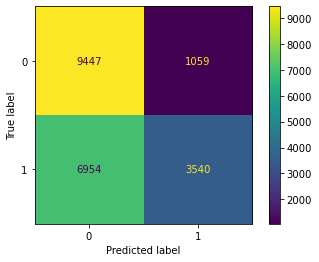

In [7]:
quant_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
# Проверка
print("Минимальные значения давления:", df['ap_hi'].min(), df['ap_lo'].min())

# Исправляем случаи, где ap_lo > ap_hi
mask = df['ap_lo'] > df['ap_hi']
df.loc[mask, ['ap_hi', 'ap_lo']] = df.loc[mask, ['ap_lo', 'ap_hi']].values

#Данные на трэйн и тест
X_quant = df[quant_features]
y = df['cardio']
Xq_train, Xq_test, y_train, y_test = train_test_split(X_quant, y, test_size=0.3, random_state=42, stratify=y)

#Обучаем GaussianNB
gnb = GaussianNB()
gnb.fit(Xq_train, y_train)
y_pred_gnb = gnb.predict(Xq_test)

#Матрица неточностей
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
print("Матрица неточностей (GaussianNB на количественных признаках):")
print(cm_gnb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gnb)
disp.plot()
plt.show()


categorical_features = ['cholesterol', 'gluc']
X_cat = df[categorical_features]

#разделяем трэйн тест
Xc_train, Xc_test, _, _ = train_test_split(X_cat, y, test_size=0.3, random_state=42, stratify=y)

**Комментарии:** Ваши комментарии здесь.

**2. Написать свой наивный байесовский классификатор для категориальных полей cholesterol, gluc. Привести матрицу неточностей и сравнить со значениями из задачи 1 (нельзя использовать готовое решение из sklearn) (не обязательно)**

Матрица неточностей (свой NB на категориальных признаках):
[[8232 2274]
 [6364 4130]]


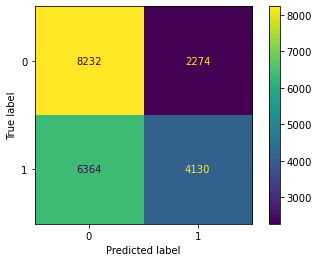

In [8]:
class CategoricalNBCustom:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.feature_probs = {}
        self.class_priors = {}
        for c in self.classes:
            X_c = X[y == c]
            self.class_priors[c] = len(X_c) / len(X)
            self.feature_probs[c] = {}
            for col in X.columns:
                counts = X_c[col].value_counts()
                total = len(X_c)

                vals = X[col].unique()
                probs = {}
                for v in vals:
                    probs[v] = (counts.get(v,0) + 1) / (total + len(vals))
                self.feature_probs[c][col] = probs

    def predict(self, X):
        y_pred = []
        for _, row in X.iterrows():
            class_probs = {}
            for c in self.classes:
                prob = self.class_priors[c]
                for col in X.columns:
                    val = row[col]
                    prob *= self.feature_probs[c][col].get(val, 1e-6)
                class_probs[c] = prob
            y_pred.append(max(class_probs, key=class_probs.get))
        return np.array(y_pred)

#Обучаем предсказываем
cat_nb = CategoricalNBCustom()
cat_nb.fit(Xc_train, y_train)
y_pred_cat = cat_nb.predict(Xc_test)

cm_cat = confusion_matrix(y_test, y_pred_cat)
print("Матрица неточностей (свой NB на категориальных признаках):")
print(cm_cat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cat)
disp.plot()
plt.show()

**Комментарии:** Ваши комментарии здесь.

**3. Построить наивный байесовский классификатор для бинарных полей gender, smoke, alco, active. Привести матрицу неточностей и сравнить с предыдущими значениями.**

Матрица неточностей (BernoulliNB на бинарных признаках):
[[8641 1865]
 [8278 2216]]


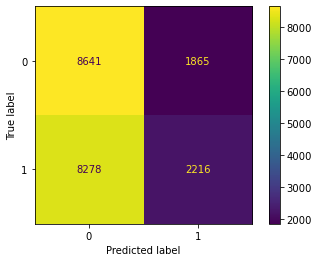

In [14]:
binary_features = ['gender', 'smoke', 'alco', 'active']
X_bin = df[binary_features]
Xb_train, Xb_test, _, _ = train_test_split(X_bin, y, test_size=0.3, random_state=42, stratify=y)

# Используем BernoulliNB из sklearn
bnb = BernoulliNB()
bnb.fit(Xb_train, y_train)
y_pred_bnb = bnb.predict(Xb_test)

cm_bnb = confusion_matrix(y_test, y_pred_bnb)
print("Матрица неточностей (BernoulliNB на бинарных признаках):")
print(cm_bnb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bnb)
disp.plot()
plt.show()





**Комментарии:** Ваши комментарии здесь.

**4. К этому моменту у вас есть три независимых классификатора: по количественным полям, категориальным и бинарным. Придумать, как их объединить в один единый классификатор, который учитывает все эти поля. Привести матрицу неточностей для него и сравнить с предыдущими значениями. Попытаться объяснить разницу.**

Матрица неточностей (объединенный классификатор):
[[9166 1340]
 [6314 4180]]


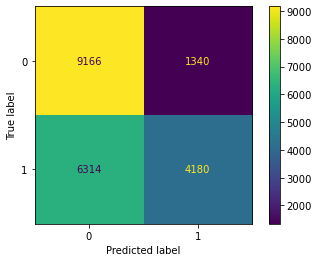

Accuracy GaussianNB (количественные): 0.6184
Accuracy свой NB (категориальные): 0.5887
Accuracy BernoulliNB (бинарные): 0.5170
Accuracy объединенный классификатор: 0.6355


In [15]:
# Для каждого классификатора получим вероятности классов для теста
y_proba_gnb = gnb.predict_proba(Xq_test)
y_proba_cat = []
for _, row in Xc_test.iterrows():
    class_probs = []
    for c in cat_nb.classes:
        prob = cat_nb.class_priors[c]
        for col in Xc_test.columns:
            val = row[col]
            prob *= cat_nb.feature_probs[c][col].get(val, 1e-6)
        class_probs.append(prob)
    # Нормализация вероятностей
    s = sum(class_probs)
    class_probs = [p/s if s>0 else 0 for p in class_probs]
    y_proba_cat.append(class_probs)
y_proba_cat = np.array(y_proba_cat)

y_proba_bnb = bnb.predict_proba(Xb_test)

# Объединяем вероятности
y_proba_combined = (y_proba_gnb + y_proba_cat + y_proba_bnb) / 3

# Предсказания объединенного классификатора
y_pred_combined = np.argmax(y_proba_combined, axis=1)

cm_combined = confusion_matrix(y_test, y_pred_combined)
print("Матрица неточностей (объединенный классификатор):")
print(cm_combined)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_combined)
disp.plot()
plt.show()
from sklearn.metrics import accuracy_score

acc_gnb = accuracy_score(y_test, y_pred_gnb)
acc_cat = accuracy_score(y_test, y_pred_cat)
acc_bnb = accuracy_score(y_test, y_pred_bnb)
acc_combined = accuracy_score(y_test, y_pred_combined)

print(f"Accuracy GaussianNB (количественные): {acc_gnb:.4f}")
print(f"Accuracy свой NB (категориальные): {acc_cat:.4f}")
print(f"Accuracy BernoulliNB (бинарные): {acc_bnb:.4f}")
print(f"Accuracy объединенный классификатор: {acc_combined:.4f}")

**Комментарии:** Ваши комментарии здесь.

**5. (Не обязательно) Теперь мы умеем делать классификацию в рамках наивного предположения об независимости всех признаков. Сейчас же нужно попробовать учесть взаимосвязь между признаками через условные вероятности. Построить классификатор с учетом такой связи. Сравнить результат с ранее полученными значениями.**

**Комментарии:** Ваши комментарии здесь.